In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# scalar value function. Takes a single value, x, and returns a single scalar, y.
def f(x):
    return 3 * x**2 - 4 * x + 5

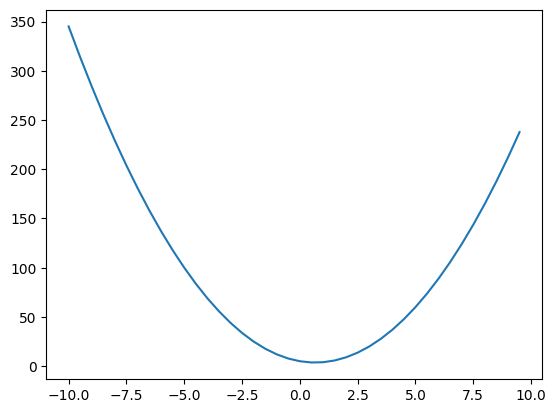

In [3]:
x = np.arange(-10, 10, 0.5)
y = f(x)
plt.plot(x, y)

Limit definition of a derivative:

$f'(x) = \lim_{h\to0} \frac{f(x + h) - f(x)}{h}$

In [4]:
h = 0.001
x1= -3.0

def f_p(x):
    return (f(x + h) - f(x)) / h
    
print(f"y = {f(x1)}")
print(f"dy/dx = {f_p(x1)}")

y = 44.0
dy/dx = -21.996999999998934


x = [0.67], y = [3.67]


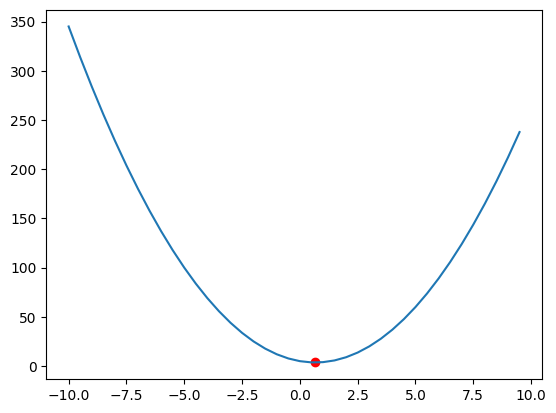

In [5]:
import scipy
from scipy import optimize

x_m = optimize.minimize(f, 3)["x"] # min x value
x = np.arange(-10, 10, 0.5)
y = f(x)
plt.plot(x, y)
plt.scatter(x_m, f(x_m), color="red") # plots the minimum value of y
print(f"x = {np.round(x_m,2)}, y = {np.round(f(x_m),2)}")

In [6]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
d

4.0

In [7]:
# derivatives of d, with respect to a, b and c
# dd/da = b
# dd/db = a
# dd/dc = 1

h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # h is the x increase, (d2 - d1) is the y increase, b is the slope.

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
# creating the Value class
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # the derivative of L with respect to the Value, e.g. a, b or c etc.
        self._backward = lambda: None  # stores how we chain the output gradient into the input gradient. By default, does nothing.
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other): # __add__ operator. Return a Value object.
        out = Value(self.data + other.data, (self, other), '+') # feed in the children of the Value
        
        def _backward():
            self.grad = 1.0 * out.grad # in addition, the self grad is equal to the out grad
            other.grad = 1.0 * out.grad # other grad will also be equal to the out grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad = other.data * out.grad # local derivative times out grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

In [9]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f # output of the graphviz graph
L.label = 'L'

In [10]:
e

Value(data=-6.0)

In [11]:
d, d._prev, d._op, d.data

(Value(data=4.0), {Value(data=-6.0), Value(data=10.0)}, '+', 4.0)

In [12]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir':'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular record node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [13]:
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6.0
L.grad = 1.0

In [14]:
# as the gradient of each leaf node (nodes that we will generally have control over) increases,
# L should increase
a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
L = d * f
L.label = 'L'
L.data

-7.286496

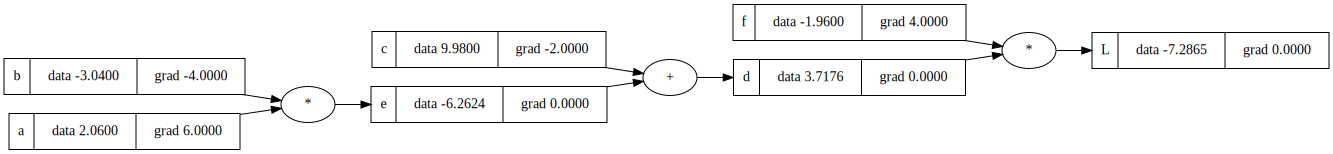

In [15]:
draw_dot(L)

Manual back propagation, the derivatives of L with respect to the Values. Applying the chain rule backwards through the graph.

L = d * f
What is dL/dd? The derivative of L with respect to d, i.e. how much L changes as d changes.
dL/dd = f

dd  / dc = ? 1

dL/dc = dd/dc * dL/dd

g(x) = c + e = d
g'(x) = dd/dc = 1
f(x) = d * f = L
f'(x) = dL/dd = f
h(x) = f(g(x))
h'(x) = f'(g(x)) * g'(x)
h'(x) = f'(c + e) * 1 = f * 1 = f

In [16]:
def lol():
    h = 0.001
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f # output of the graphviz graph
    L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 + h, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f # output of the graphviz graph
    L.label = 'L'
    L2 = L.data
    
    print((L2 - L1) / h) # the derivative of L with respect to a, how much L changes as a changes.

lol()

6.000000000000227


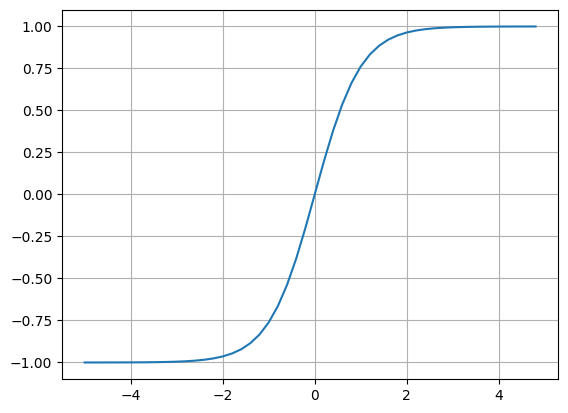

In [17]:
# activation function, tanh
x = np.arange(-5, 5, 0.2)
plt.plot(x, np.tanh(x))
plt.grid()

In [18]:
# inputs x1, x2. Neuron with two inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights of the neuron, w1, w2. The weights by which the inputs are multiplied.
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
C = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n" # n is the raw neuron activation (without the activation function)

o = n.tanh(); o.label = 'o' # o is n with the activation function applied.

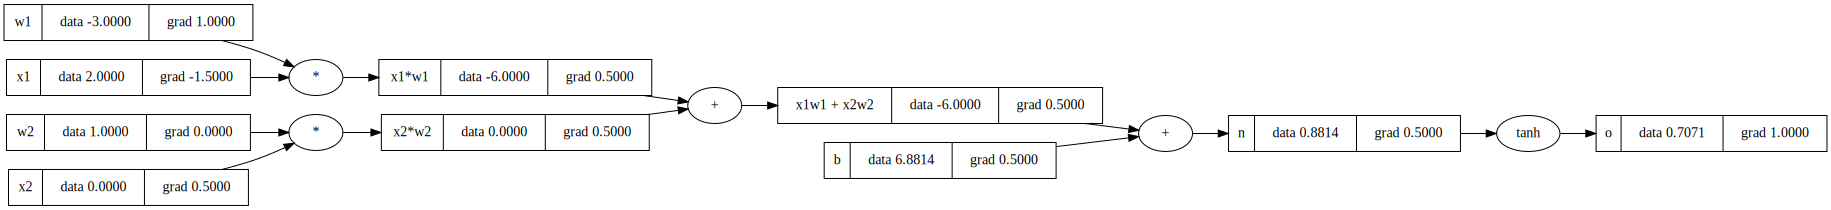

In [33]:
draw_dot(o)

In [20]:
o.grad = 1.0 # intialise o grad

In [21]:
o._backward()

In [22]:
n._backward()

In [23]:
b._backward()

In [24]:
x1w1x2w2._backward()

In [25]:
x2w2._backward()

In [26]:
x1w1._backward()

In [27]:
# x1w1 = x1 * w1
# dx1w1/dw1 = x1 = 2.0
# dL/dw1 = dx1w1/dw1 * dL/x1w1x2w2 = 2.0 * 0.5 = 1

In [28]:
x2.grad = w2.data * x2w2.grad # dL/dx2
w2.grad = x2.data * x2w2.grad # dL/dw2
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [29]:
x1w1x2w2.grad = 0.5
b.grad = 0.5 # bias gradient is equal to the gradient of the corresponding neuron
x1w1.grad = 0.5
x2w2.grad = 0.5
# w1.grad = 1.0


In [30]:
n.grad = 0.5

In [31]:
# derivative of o with respect to the input weights w1, w2
o.grad = 1.0 # derivate of o with respect to o

# do/dn , derivative of o with respect to n
# n.grad = 1 - tanh(n)**2
# = 1 - o**2 , tanh(n) is equal to o


In [32]:
# https://youtu.be/VMj-3S1tku0?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=4640